In [1]:
import torch
import sys


def system_check():
    print(f"--- Python Version: {sys.version.split()[0]} ---")
    print(f"--- PyTorch Version: {torch.__version__} ---")

    if torch.cuda.is_available():
        print(f"CUDA is available! Device: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA not available (Running on CPU)")

system_check()

--- Python Version: 3.11.14 ---
--- PyTorch Version: 2.6.0+cu124 ---
CUDA not available (Running on CPU)


In [2]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import DistilBertTokenizer
from IPython.display import Image as IPImage, display

# Force reload model module (in case of cached old version)
import importlib
import model as model_module
importlib.reload(model_module)
from model import ViralPredictor

# --- CONFIGURATION ---
MODEL_PATH = "data/models/viral_predictor.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Define transformations (MUST match training transforms)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 2. Model loading function
def load_model():
    print(f"Loading model from {MODEL_PATH}...")
    model = ViralPredictor()
    # Load weights (state_dict)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()  # IMPORTANT: Switches model to test mode (disables Dropout etc.)
    return model


# 3. Prediction function (Inference)
def predict_viral(model, image_path, title_text):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # A. Image Preparation
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        return "Error: Image file not found."

    # Add batch dimension (Model expects [1, 3, 224, 224], not [3, 224, 224])
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # B. Text Preparation
    text_inputs = tokenizer(
        title_text,
        return_tensors="pt",
        padding='max_length',
        truncation=True,
        max_length=50
    )
    input_ids = text_inputs['input_ids'].to(DEVICE)
    attention_mask = text_inputs['attention_mask'].to(DEVICE)

    # C. Prediction
    with torch.no_grad():  # Disable gradient computation (saves memory)
        prediction = model(image_tensor, input_ids, attention_mask)

    # Extract number from tensor
    score = prediction.item()
    return score


def print_verdict(score, title, image_path):
    """Helper function to print prediction results."""
    print(f"\nTitle: {title}")
    print(f"File: {image_path}")
    display(IPImage(filename=test_image, width=400))
    print(f"Viral Probability: {score:.2%}")

    if score > 0.6:
        print(">> VERDICT: 🔥 POTENTIAL VIRAL!")
    elif score < 0.4:
        print(">> VERDICT: 💀 WEAK...")
    else:
        print(">> VERDICT: 😐 Average")



In [3]:
model = load_model()

print("-" * 30)
print("VIRALITY TESTER")
print("-" * 30)

Loading model from data/models/viral_predictor.pth...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.4MB/s]


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


------------------------------
VIRALITY TESTER
------------------------------


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Title: МОРГЕНШТЕРН — Группа Крови (Live in Poland 2025) Полная версия
File: data/test/test1.jpg


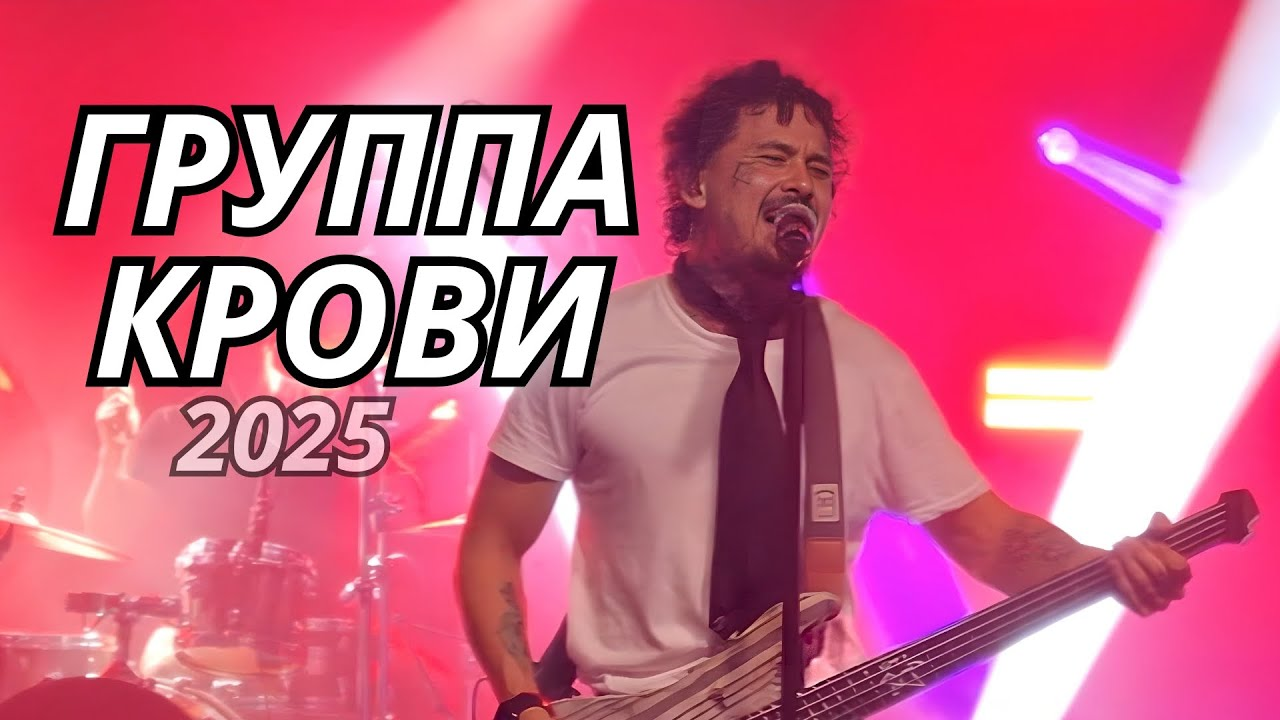

Viral Probability: 57.36%
>> VERDICT: 😐 Average


In [4]:
# Test 1
test_image = "data/test/test1.jpg"
test_title = "МОРГЕНШТЕРН — Группа Крови (Live in Poland 2025) Полная версия"
score = predict_viral(model, test_image, test_title)
print_verdict(score, test_title, test_image)


Title: How I Transformed VS Code Into a Cozy Workspace #devsetup
File: data/test/test2.jpg


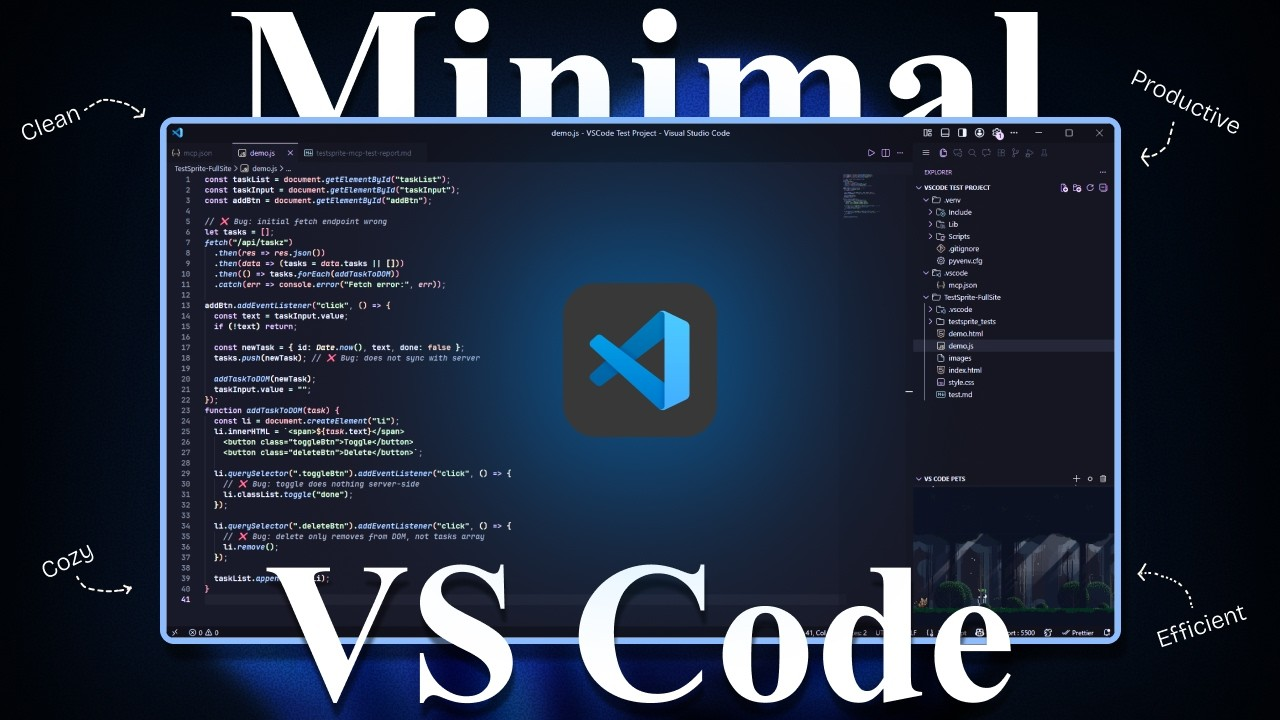

Viral Probability: 72.66%
>> VERDICT: 🔥 POTENTIAL VIRAL!


In [5]:
# Test 2
test_image = "data/test/test2.jpg"
test_title = "How I Transformed VS Code Into a Cozy Workspace #devsetup"
score = predict_viral(model, test_image, test_title)
print_verdict(score, test_title, test_image)



Title: How I Code Profitable Apps SOLO (Idea + Build + Marketing Guide)
File: data/test/test3.jpg


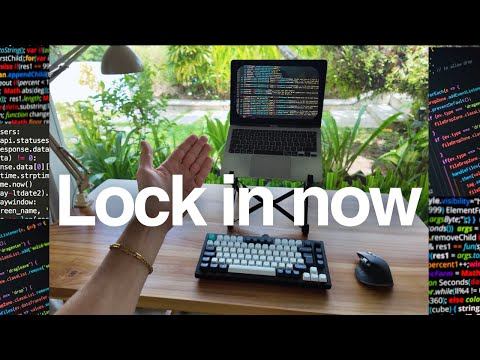

Viral Probability: 81.04%
>> VERDICT: 🔥 POTENTIAL VIRAL!


In [6]:
# Test 3
test_image = "data/test/test3.jpg"
test_title = "How I Code Profitable Apps SOLO (Idea + Build + Marketing Guide)"
score = predict_viral(model, test_image, test_title)
print_verdict(score, test_title, test_image)


In [7]:
# Test 4
test_image = "data/test/test4.jpeg"
test_title = 'Michael Jackson\'s Drummer Jonathan Moffett Performs "Smooth Criminal"'
score = predict_viral(model, test_image, test_title)
print_verdict(score, test_title, test_image)



Title: Michael Jackson's Drummer Jonathan Moffett Performs "Smooth Criminal"
File: data/test/test4.jpeg


Viral Probability: 77.37%
>> VERDICT: 🔥 POTENTIAL VIRAL!



Title: Year summary 2025
File: data/test/test5.jpg


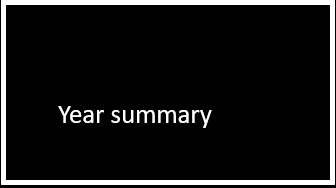

Viral Probability: 21.59%
>> VERDICT: 💀 WEAK...


In [8]:
# Test 5
test_image = "data/test/test5.jpg"
test_title = 'Year summary 2025'
score = predict_viral(model, test_image, test_title)
print_verdict(score, test_title, test_image)
